In [1]:
%%time
import bayes3d as b
import jax.numpy as jnp
import jax
import numpy as np
from tqdm import tqdm
import bayes3d.o3d_viz
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
CPU times: user 5.33 s, sys: 1.68 s, total: 7.01 s
Wall time: 4.78 s


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=5.0
)

renderer = b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
contact_plane = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
key = jax.random.PRNGKey(2100)

2.1556137
5.0


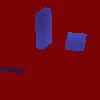

In [5]:
key = jax.random.split(key)[1]
indices = jax.random.choice(key,21,shape=(3,))
contact_params = jax.random.uniform(
    key,
    shape=(3,3,),
    minval=jnp.array([-0.2,-0.2, 0.0]),
    maxval=jnp.array([0.2, 0.2, 2*jnp.pi])
)
faces = jnp.array([3,3,3])
dims_child = b.RENDERER.model_box_dims[indices]
poses_ground_truth = contact_plane @ b.scene_graph.relative_pose_from_edge_parallel_jit(
    contact_params, faces, dims_child
)
observed_point_cloud_image = b.RENDERER.render_multiobject(poses_ground_truth, indices)[...,:3]
print(jnp.min(observed_point_cloud_image[:,:,2]))
print(jnp.max(observed_point_cloud_image[:,:,2]))
b.get_depth_image(observed_point_cloud_image[:,:,2])

In [6]:
grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.05, jnp.pi/5, (11,11,1)),
    (0.05, jnp.pi/5, (11,11,11)), (0.0, jnp.pi/6, (1,1,51)), (0.0, jnp.pi, (1,1,51))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [7]:
threedp3_likelihood_full_hierarchical_bayes_per_pixel_jit = jax.jit(jax.vmap(jax.vmap(jax.vmap(
    b.threedp3_likelihood_per_pixel_jit,
       in_axes=(None, None, None, 0, None, None)),
       in_axes=(None, None, 0, None, None, None)),
       in_axes=(None, 0, None, None, None, None)
), static_argnames=('filter_size',))

In [8]:
VARIANCE_GRID = jnp.array([ 0.0001])
OUTLIER_GRID = jnp.array([0.01])
OUTLIER_VOLUME = 1000.0

In [10]:
gt_trace = b.Trace(
    poses_ground_truth , indices, VARIANCE_GRID[0], OUTLIER_GRID[0], OUTLIER_VOLUME,
    observed_point_cloud_image
)
print(b.score_trace(gt_trace))

trace = b.Trace(
    jnp.zeros((0,4,4)), jnp.array([],dtype=jnp.int32),
    VARIANCE_GRID[0], OUTLIER_GRID[0], OUTLIER_VOLUME,
    observed_point_cloud_image
)

37315.29


In [15]:
%%time
for _ in range(1):
    all_paths = []
    for obj_id in tqdm(range(len(b.RENDERER.meshes))):
        contact_param = jnp.zeros(3)
        p = None
        trace_path = []
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param, trace_ = b.c2f.c2f_iter_trace_contact_params_jit(trace, contact_param, contact_param_gridding_schedule[c2f_iter], contact_plane, b.RENDERER.model_box_dims[obj_id], obj_id, 3, VARIANCE_GRID, OUTLIER_GRID)
            trace_path.append(trace_)

        all_paths.append(
            trace_path
        )
    scores = jnp.array([b.score_trace(t[-1]) for t in all_paths])
    print(scores)
    normalized_scores = b.utils.normalize_log_scores(scores)
    # print(["{:0.3f}".format(n) for n in normalized_scores])
    order = jnp.argsort(-scores)
    # print(order)
    new_trace = all_paths[jnp.argmax(scores)][-1]
    trace = new_trace
    b.viz_trace_meshcat(trace)


100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


[35627.234 35894.168 35941.43  35899.15  35938.676 35945.414 36067.754
 36161.28  35918.29  36901.727 35627.234 35985.84  35627.234 36150.875
 36030.777 35627.234 37179.58  37219.    36776.03  37128.28  35974.234]
CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 7.85 s


In [77]:
trace.ids

Array([0], dtype=int32)

In [ ]:
b.viz_trace_meshcat(new_trace, renderer)

In [ ]:
b.viz_trace_meshcat(trace, renderer)
trace.ids

In [280]:
t = all_paths[0][0]
b.viz_trace_meshcat(t, renderer)
b.score_trace(t, renderer)

Array(50328.914, dtype=float32)

In [281]:
[(b.score_trace(t, renderer),t.variance, t.outlier_prob, t.outlier_volume) for t in all_paths[0]]

[(Array(50328.914, dtype=float32),
  Array(5.e-05, dtype=float32),
  Array(0.01, dtype=float32),
  0.01),
 (Array(50397.914, dtype=float32),
  Array(5.e-05, dtype=float32),
  Array(0.01, dtype=float32),
  0.01),
 (Array(50397.914, dtype=float32),
  Array(5.e-05, dtype=float32),
  Array(0.01, dtype=float32),
  0.01),
 (Array(50397.914, dtype=float32),
  Array(5.e-05, dtype=float32),
  Array(0.01, dtype=float32),
  0.01),
 (Array(50397.914, dtype=float32),
  Array(5.e-05, dtype=float32),
  Array(0.01, dtype=float32),
  0.01),
 (Array(50397.914, dtype=float32),
  Array(5.e-05, dtype=float32),
  Array(0.01, dtype=float32),
  0.01),
 (Array(50397.914, dtype=float32),
  Array(5.e-05, dtype=float32),
  Array(0.01, dtype=float32),
  0.01),
 (Array(50397.914, dtype=float32),
  Array(5.e-05, dtype=float32),
  Array(0.01, dtype=float32),
  0.01),
 (Array(50397.914, dtype=float32),
  Array(5.e-05, dtype=float32),
  Array(0.01, dtype=float32),
  0.01),
 (Array(50397.914, dtype=float32),
  Array(5.e

In [278]:
print(all_paths[0][0])

variance: 4.999999873689376e-05 outlier_prob: 0.009999999776482582 outlier_volume: 0.01
 ids: [1, 1, 1, 0, 0, 0, 0] poses: [[[-1.0000000e+00  2.6187897e-03 -6.1583705e-08 -3.0322266e-01]
  [ 1.4526611e-03  5.5468750e-01 -8.3203125e-01  1.5621534e-01]
  [-2.1788806e-03 -8.3203125e-01 -5.5468750e-01  1.5503801e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 1.0000000e+00 -2.6187897e-03 -6.2049367e-08 -2.9663086e-01]
  [-1.4526611e-03 -5.5468738e-01 -8.3203131e-01 -1.7651589e-01]
  [ 2.1788806e-03  8.3203131e-01 -5.5468738e-01  2.0494769e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 2.6187897e-03 -1.0000000e+00 -1.4924444e-07  2.9663086e-01]
  [-5.5468744e-01 -1.4524856e-03 -8.3203125e-01 -1.7651589e-01]
  [ 8.3203125e-01  2.1789977e-03 -5.5468744e-01  2.0494769e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 3.2992102e-07 -1.0000000e+00 -1.4924444e-07  4.4995117e-01]
  [-5.5468744e-01 -1.2495093e-07 -8.320

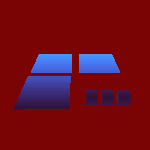

In [83]:
reconstruction = b.render_image(trace, renderer)
b.get_depth_image(reconstruction[:,:,2])

1e-04 0.0005 0.0005


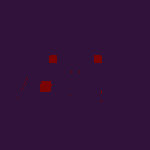

In [84]:
print(trace.variance, trace.outlier_prob, trace.outlier_volume)
p = b.threedp3_likelihood_per_pixel_jit(
    trace.observation, reconstruction[:,:,:3],
    trace.variance, 0.0, 1.0,
    3
)
outlier_density = jnp.log(trace.outlier_prob) - jnp.log(0.0005)
b.get_depth_image(1.0 * (outlier_density > p), min=0.0, max=1.0)

In [90]:
potential_new_trace = all_traces[0]
potential_new_trace.poses = potential_new_trace.poses.at[-1].set(poses[4])
b.viz_trace_meshcat(potential_new_trace, renderer)

In [93]:
print(b.score_trace(trace, renderer))
print(b.score_trace(potential_new_trace, renderer))

33080.508
33209.13


In [86]:
b.viz_trace_meshcat(all_traces[1], renderer)

In [78]:
b.clear()
seg = b.render_image(trace, renderer)[:,:,3]
# b.show_cloud("rerender", b.render_image(trace,renderer)[:,:,:3].reshape(-1,3),color=b.RED)

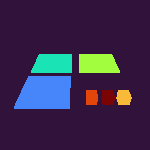

In [79]:
b.get_depth_image(seg)

In [27]:
trace.variance

Array(5.e-05, dtype=float32)

In [25]:
inferred_colors = []
distinct_colors = jnp.array(distinct_colors)
for i in range(1,len(trace.ids)+1):
    seg_colors = rgbd.rgb[seg == i ,:3]
    distances = jnp.abs(seg_colors[:,None,:]/255.0 - distinct_colors[None,...]).sum(-1)
    values, counts = np.unique(jnp.argmin(distances,axis=-1), return_counts=True)
    inferred_colors.append(values[counts.argmax()])
inferred_colors

[0, 0, 1, 0, 1, 2, 2]

In [26]:
trace.ids

[3, 1, 2, 0, 0, 2, 2]

In [27]:
color

Array([0, 1, 2, 2, 0, 0, 1], dtype=int32)

In [28]:
ids

Array([0, 1, 2, 2, 3, 1, 2], dtype=int32)

In [35]:
distinct_colors = jnp.array(distinct_colors)

0

In [43]:
distances

Array([[265.38788, 265.23517, 265.21304, 264.7006 ],
       [264.38788, 264.23517, 264.21304, 263.7006 ],
       [264.38788, 264.23517, 264.21304, 263.7006 ],
       ...,
       [218.38788, 218.23515, 218.21304, 217.70059],
       [218.38788, 218.23515, 218.21304, 217.70059],
       [220.38788, 220.23515, 220.21304, 219.70059]], dtype=float32)

In [32]:
seg_colors

array([[102.,  91.,  74., 255.],
       [102.,  90.,  74., 255.],
       [102.,  90.,  74., 255.],
       ...,
       [ 56.,  60., 104., 255.],
       [ 56.,  60., 104., 255.],
       [ 57.,  61., 104., 255.]], dtype=float32)

In [14]:
## b.score_trace(gt_trace, renderer, filter_size=i)

In [15]:
x = b.render_image(gt_trace, renderer)[:,:,:3]
b.clear()
b.show_cloud("1", x.reshape(-1,3))

In [ ]:
b

In [28]:
scores

Array([46415184., 46415184., 46415184., 46415184.], dtype=float32)

0
39.143948
1
39.143948
2
39.143948
3
39.143948
4
39.143948
5
39.143948


[15 14]


Array([[4.21553057e-31, 2.49202155e-21, 1.81754445e-15, 1.63620419e-13,
        1.81767426e-15, 2.49202155e-21, 4.21643100e-31],
       [2.49113297e-21, 1.47263955e-11, 1.07406295e-05, 9.66901367e-04,
        1.07413971e-05, 1.47263955e-11, 2.49166531e-21],
       [1.81728611e-15, 1.07429332e-05, 7.83530903e+00, 7.05356323e+02,
        7.83586931e+00, 1.07429332e-05, 1.81767426e-15],
       [1.63585481e-13, 9.67039727e-04, 7.05305969e+02, 6.34936094e+04,
        7.05356323e+02, 9.67039727e-04, 1.63620419e-13],
       [1.81728611e-15, 1.07429332e-05, 7.83530903e+00, 7.05356323e+02,
        7.83586931e+00, 1.07429332e-05, 1.81767426e-15],
       [2.49148921e-21, 1.47285031e-11, 1.07421656e-05, 9.67039727e-04,
        1.07429332e-05, 1.47285031e-11, 2.49202155e-21],
       [4.21553057e-31, 2.49202155e-21, 1.81754445e-15, 1.63620419e-13,
        1.81767426e-15, 2.49202155e-21, 4.21643100e-31]], dtype=float32)

Array([[[2.6608486, 2.6608543, 3.9894223],
        [3.332247 , 2.6608543, 3.9894223],
        [3.8138752, 2.6608543, 3.9894223],
        [3.9894223, 2.6608543, 3.9894223],
        [3.813878 , 2.6608543, 3.9894223],
        [3.332247 , 2.6608543, 3.9894223],
        [2.6608543, 2.6608543, 3.9894223]],

       [[2.6608486, 3.3322425, 3.9894223],
        [3.332247 , 3.3322425, 3.9894223],
        [3.8138752, 3.3322425, 3.9894223],
        [3.9894223, 3.3322425, 3.9894223],
        [3.813878 , 3.3322425, 3.9894223],
        [3.332247 , 3.3322425, 3.9894223],
        [2.6608543, 3.3322425, 3.9894223]],

       [[2.6608486, 3.813878 , 3.9894223],
        [3.332247 , 3.813878 , 3.9894223],
        [3.8138752, 3.813878 , 3.9894223],
        [3.9894223, 3.813878 , 3.9894223],
        [3.813878 , 3.813878 , 3.9894223],
        [3.332247 , 3.813878 , 3.9894223],
        [2.6608543, 3.813878 , 3.9894223]],

       [[2.6608486, 3.9894223, 3.9894223],
        [3.332247 , 3.9894223, 3.9894223],
     

In [ ]:
# object_types: cube, sphere, pyramid, pad
# Output
# List of (object_type, color, contact_params)